In [1578]:
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
from scipy.ndimage import label, find_objects
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator
import cv2
import os

### Check if the Image Has Low Contrast

In [311]:
def measure_contrast(image, threshold=245, overexposure_ratio=0.3):
    """
    Detects if an image is overexposed.

    Parameters:
    - image: Input image (numpy array).
    - threshold: Pixel value threshold to consider a pixel overexposed.
    - overexposure_ratio: Proportion of pixels above the threshold to classify the image as overexposed.

    Returns:
    - Boolean indicating if the image is overexposed.
    """
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    # Calculate the histogram of pixel values
    hist = cv2.calcHist([gray_image], [0], None, [256], [0, 256])
    hist = hist / hist.sum()

    # Calculate the proportion of pixels above the threshold
    overexposed_pixels = hist[threshold:].sum()

    return overexposed_pixels > overexposure_ratio, overexposed_pixels

# check all the images in the folder and print the path of overexposed ones
def check_overexposed(folder_path):
    for file in os.listdir(folder_path):
        if file.endswith(".jpg"):
            image_path = os.path.join(folder_path, file)
            try:
                image = Image.open(image_path).convert("RGB")
            except:
                print("File problem", image_path)
                continue
            image = np.array(image)
            has_low_contrast, overexposed_pixels = measure_contrast(image)
            if has_low_contrast:
                print("Overexposed image", overexposed_pixels, image_path)


folder_path = "C:/Users/jflir/Documents/Arbocensus/ArbocensusData/20230829_24"
check_overexposed(folder_path)

Overexposed image 0.40024167 C:/Users/jflir/Documents/Arbocensus/ArbocensusData/20230829_24\10272-0.jpg
Overexposed image 0.313475 C:/Users/jflir/Documents/Arbocensus/ArbocensusData/20230829_24\13524-0.jpg
Overexposed image 0.37093958 C:/Users/jflir/Documents/Arbocensus/ArbocensusData/20230829_24\139145-0.jpg
File problem C:/Users/jflir/Documents/Arbocensus/ArbocensusData/20230829_24\139224-0.jpg
Overexposed image 0.3342521 C:/Users/jflir/Documents/Arbocensus/ArbocensusData/20230829_24\15170-0.jpg
Overexposed image 0.4255271 C:/Users/jflir/Documents/Arbocensus/ArbocensusData/20230829_24\15578-0.jpg
File problem C:/Users/jflir/Documents/Arbocensus/ArbocensusData/20230829_24\30131-0.jpg
File problem C:/Users/jflir/Documents/Arbocensus/ArbocensusData/20230829_24\53962-0.jpg
Overexposed image 0.3156125 C:/Users/jflir/Documents/Arbocensus/ArbocensusData/20230829_24\71639-0.jpg
File problem C:/Users/jflir/Documents/Arbocensus/ArbocensusData/20230829_24\74450-0.jpg
Overexposed image 0.3575645

### 1) Open the File and Validate if its Saved Correctly

In [2165]:
folder_path = "C:/Users/jflir/Documents/Arbocensus/ArbocensusData/20230829_24/"

#get a random image from a folder path
def get_random_image(folder_path):
    files = os.listdir(folder_path)
    image_path = folder_path + files[np.random.randint(len(files))]
    return image_path

test_image_path = get_random_image(folder_path)
# test_image_path = 'C:/Users/jflir/Documents/Arbocensus/ArbocensusData/20230829_24/24140-0.jpg'


#validate the image exists and is a valid image file
try:
    test_image = Image.open(test_image_path).convert("RGB")
except FileNotFoundError:
    print("File not found")
except IOError:
    print("Not a valid image file")
else:
    print("File found and valid image file")

#transform to an ndarray
test_image = np.array(test_image)
size = test_image.shape[:2]
center = [size[1]//2, size[0]//2]
print(center)
print(size)

x_deviation = (size[1]//2) / 1.10
y_deviation = (size[0]//2) / 1.10
left_bottom_corner = [center[0] - x_deviation + 50, center[1] + (size[0]//2)/2]
right_bottom_corner = [center[0] + x_deviation - 50, center[1] + (size[0]//2)/2]
top_left_corner = [center[0] - x_deviation + 20, center[1] - y_deviation]
top_right_corner = [center[0] + x_deviation - 20, center[1] - y_deviation]
bottom_center = [center[0], center[1] + size[0]//6]
top_center = [center[0], center[1] - size[0]//6]

reference_points = [center, bottom_center, top_center, left_bottom_corner, right_bottom_corner, top_left_corner, top_right_corner]
input_points = np.array(reference_points)
input_label = np.array([1, 1, 1, 0, 0, 0, 0])


File found and valid image file
[300, 400]
(800, 600)


In [2166]:
measure_contrast(test_image)

(False, 0.28825417)

In [2167]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    print(h, w, mask)
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]

    print(pos_points, neg_points)
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [2168]:
import torch

# Your code here...

# When you want to release GPU memory:
torch.cuda.empty_cache()

[[300. 400.]
 [300. 533.]
 [300. 267.]] [[ 77.27272727 600.        ]
 [522.72727273 600.        ]
 [ 47.27272727  36.36363636]
 [552.72727273  36.36363636]]


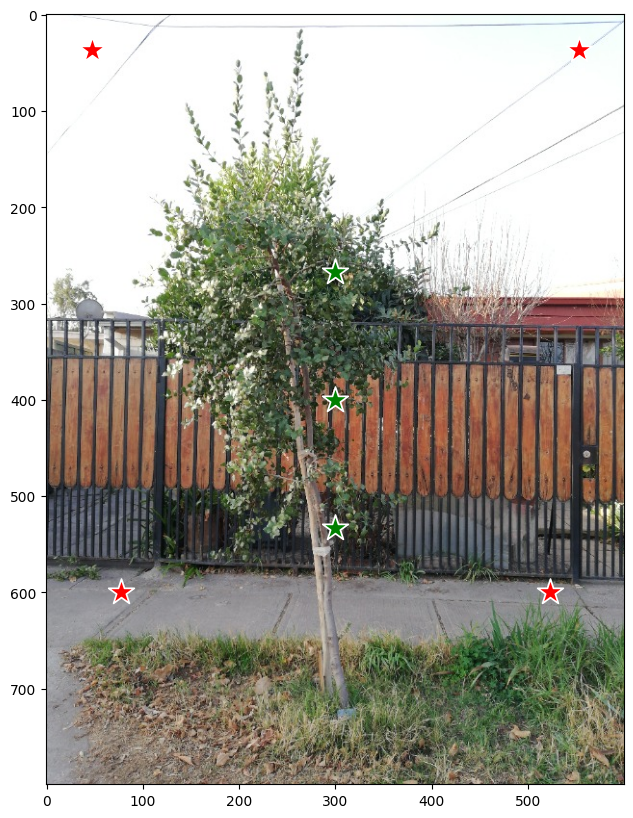

In [2169]:
plt.figure(figsize=(10,10))
plt.imshow(test_image)
show_points(input_points, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [2170]:
input_box = np.array([0, 0, 600, 800])

In [2171]:
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

predictor.set_image(test_image)


masks, scores, logits = predictor.predict(
    point_coords=input_points,
    point_labels=input_label,
    multimask_output=False,
    box=input_box,
)

mask = masks[0]
score = scores[0]

In [2172]:
from scipy.ndimage import label

def isolate_largest_segment(mask):
    """
    Isolates the largest closed segment in a boolean mask.

    Parameters:
    - mask: Input boolean mask (numpy array).

    Returns:
    - A boolean mask with only the largest closed segment.
    """
    # Label connected components
    labeled_mask, num_features = label(mask)
    
    if num_features == 0:
        # No segments found
        return np.zeros_like(mask, dtype=bool)
    
    # Find the sizes of each segment
    segment_sizes = np.bincount(labeled_mask.flat)
    # Ignore the background label (0)
    segment_sizes[0] = 0
    
    # Identify the largest segment
    largest_segment_label = segment_sizes.argmax()
    
    # Create a mask for the largest segment
    largest_segment_mask = labeled_mask == largest_segment_label
    
    return largest_segment_mask
mask = masks[0]
score = scores[0]

isolated_mask = isolate_largest_segment(mask)

800 600 [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
[[300. 400.]
 [300. 533.]
 [300. 267.]] [[ 77.27272727 600.        ]
 [522.72727273 600.        ]
 [ 47.27272727  36.36363636]
 [552.72727273  36.36363636]]


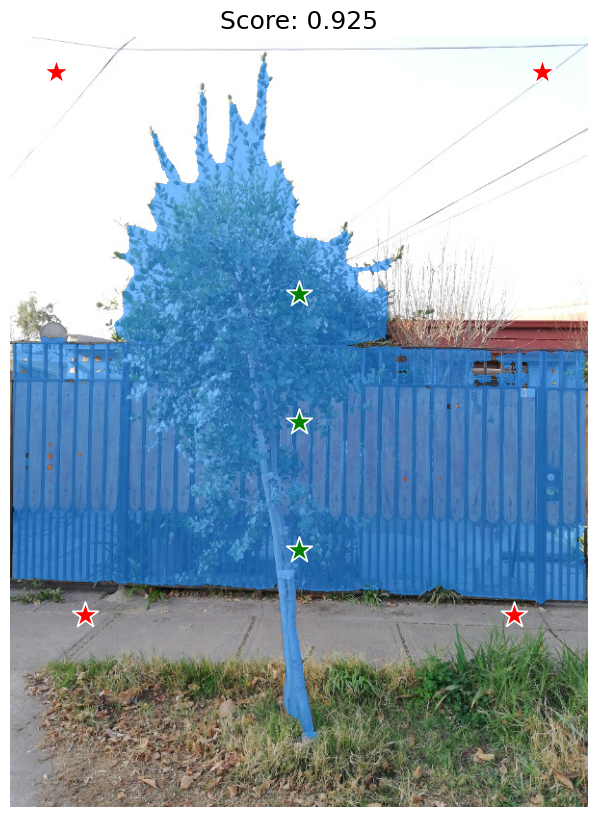

In [2173]:
plt.figure(figsize=(10,10))
plt.imshow(test_image)
show_mask(isolated_mask, plt.gca())
show_points(input_points, input_label, plt.gca())
plt.title(f"Score: {score:.3f}", fontsize=18)
plt.axis('off')
plt.show()


  

### Segunda Segmentación

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

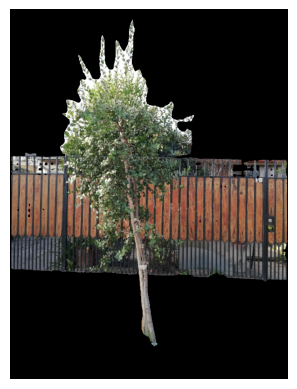

In [2174]:
#given a mask change the false values to 255 in the image
def mask_to_image(mask, image):
    for i in range(len(mask)):
        for j in range(len(mask[i])):
            if mask[i][j] == False:
                image[i][j] = 0
    return image

isolated_test_image = test_image.copy()
isolated_test_image = mask_to_image(isolated_mask, isolated_test_image)

print(isolated_mask[0])

#display the image
plt.imshow(isolated_test_image)
plt.axis('off')
plt.show()


In [2175]:
mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(test_image)

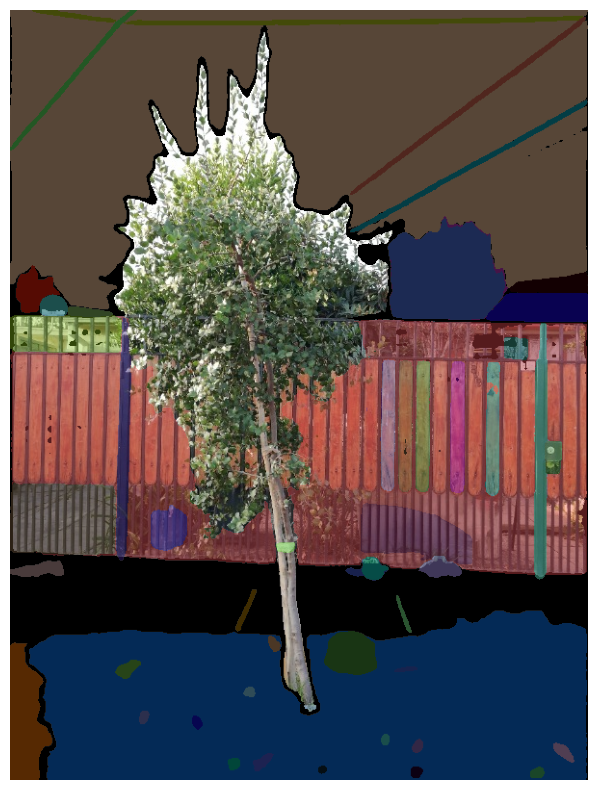

In [2176]:
plt.figure(figsize=(10,10))
plt.imshow(isolated_test_image)
show_anns(masks)
plt.axis('off')
plt.show() 

for mask in masks:
    mask['segmentation'] = isolate_largest_segment(mask['segmentation'])

In [2177]:
def diametros_mascara_con_falsos(mascara):
    h, w = mascara.shape
    diametros = np.zeros(h, dtype=int)
    filas_con_falsos = []
    
    for i in range(h):
        if np.any(mascara[i]):
            indices_true = np.where(mascara[i])[0]
            diametro = indices_true[-1] - indices_true[0] + 1
            
            # Chequear si hay algún False entre el primer y último True
            if np.any(~mascara[i, indices_true[0]:indices_true[-1] + 1]):
                filas_con_falsos.append(i)
        else:
            diametro = 0
        
        diametros[i] = diametro
    
    return diametros[::-1], filas_con_falsos


best_mask = isolated_mask
diameters, mask_breaks = diametros_mascara_con_falsos(best_mask)
diameters, mask_breaks

(array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   3,   4,   8,  12,  12,  13,  13,
         10,  10,  10,  13,  14,  14,  13,  13,  13,  13,  14,  14,  15,
         15,  19,  19,  21,  23,  24,  25,  24,  25,  25,  26,  25,  25,
         26,  26,  27,  26,  26,  26,  26,  26,  25,  25,  25,  25,  25,
         24,  24,  24,  24,  24,  23,  23,  23,  23,  23,  22,  22,  21,
         21,  21,  21,  20,  19,  19,  19,  19,  19,  18,  18,  18,  18,
         18,  18,  18,  18,  18,  17,  17,  17,  18,  18,  17,  17,  17,
         18,  18,  18,  18,  18,  18,  17,  17,  18,  18,  18,  18,  17,
         17,  17,  17,  17,  16,  16,  16,  16,  16

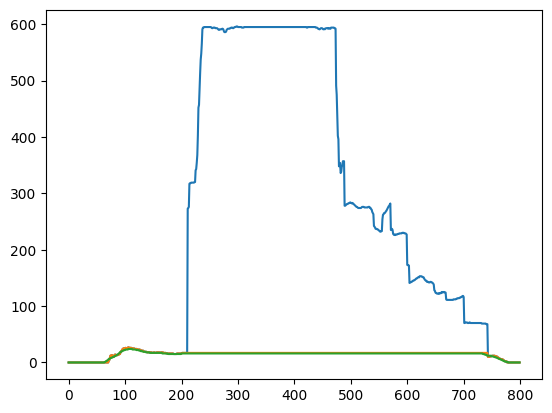

In [2178]:
#replace outlier diameters with the mean
def get_threshold(data):
    test_data = [np.abs(data[i] - data[i-1]) for i in range(len(data)) if i != 0]
    return np.average(test_data) + 2*np.std(test_data)

def replace_outliers(data, threshold=25):
    new_data = data.copy()
    for i in range(len(new_data)):
        if i == 0 or i == len(new_data) - 1 or i == 1:
            continue
        if np.abs(new_data[i-1] - new_data[i]) > threshold:
            new_data[i] = new_data[i-1] + (new_data[i-1] - new_data[i-2])
    return new_data

def mean_average_window_filter(data, window_size=3):
    new_data = data.copy()
    for i in range(len(new_data)):
        if i < window_size or i >= len(new_data) - window_size:
            continue
        new_data[i] = np.mean(new_data[i-window_size:i+window_size+1])
    return new_data
    

th = get_threshold(diameters)

filtered_diameters_outliers = replace_outliers(diameters, threshold=th)
filtered_diameters = mean_average_window_filter(filtered_diameters_outliers, window_size=10)

#plot the diameters

plt.plot(diameters)
plt.plot(filtered_diameters_outliers)
plt.plot(filtered_diameters)

plt.show()

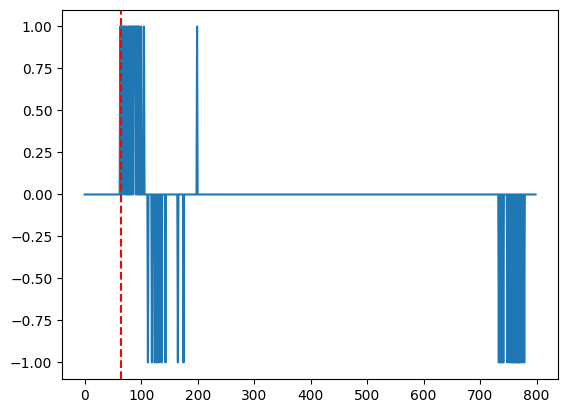

64

In [2179]:
def primer_punto_inflexion(datos):
    # Convertir los datos a un array de numpy
    datos = np.array(datos)
    
    # Calcular la primera derivada
    primera_derivada = np.diff(datos)
    
    # Calcular la segunda derivada
    segunda_derivada = np.diff(primera_derivada)
    
    # Encontrar el primer punto donde la segunda derivada cambia de signo
    a = 0
    for i in range(1, len(segunda_derivada)):
        if segunda_derivada[i-1] * segunda_derivada[i] < 0:
            return i + 1  # +1 debido a la diferencia de longitud tras la derivada  
    
    return None

def get_mode(arr):
    if len(arr) == 0:
        return None

    values, counts = np.unique(arr, return_counts=True)
    max_count_index = np.argmax(counts)
    mode = values[max_count_index]

    return mode


def get_first_inflection_point(datos):
    # Convertir los datos a un array de numpy
    datos = np.array(datos)
    
    # Calcular la primera derivada
    primera_derivada = np.diff(datos)

    moda = get_mode(primera_derivada[primera_derivada > 0])

    my_inflection_point = None
    for i in range(len(primera_derivada)):
        if primera_derivada[i] > moda:
            if i > datos.shape[0] * 0.25:
                my_inflection_point = i
                break
    
    if my_inflection_point is None:
        my_inflection_point = primer_punto_inflexion(datos)

    # Graficar la primera derivada
    plt.plot(primera_derivada)
    plt.axvline(x=my_inflection_point, color='r', linestyle='--')
    plt.show()
    
    return my_inflection_point


punto_inflexion = get_first_inflection_point(filtered_diameters)
punto_inflexion

64


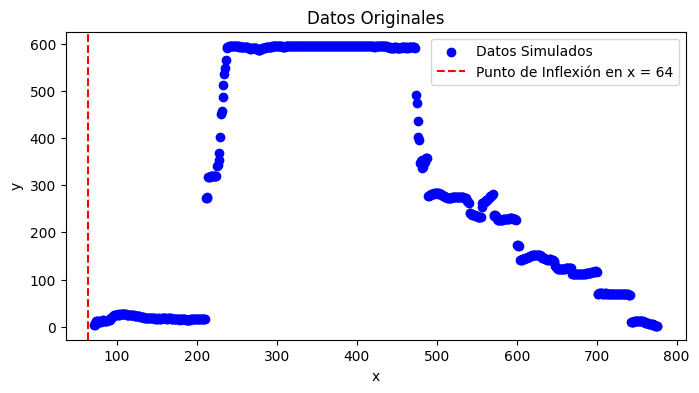

64


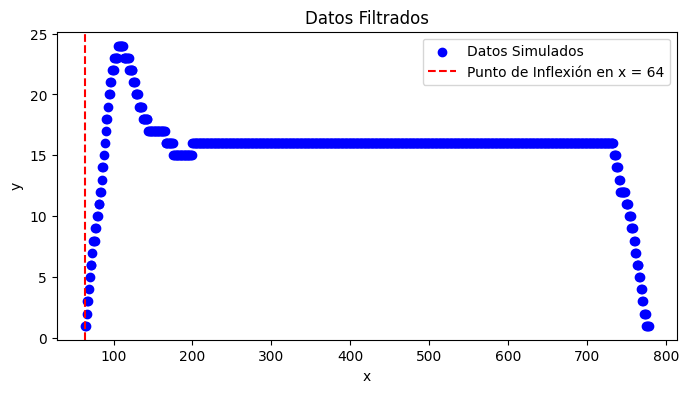

In [2180]:
import numpy as np
import matplotlib.pyplot as plt

def graficar_datos_simulados(longest_segment, punto_inflexion, titulo='Datos Simulados'):
  # Generar datos simulados con ruido
  x_data = np.linspace(0, longest_segment.shape[0], longest_segment.shape[0], dtype=int)
  y_data = longest_segment


  #comenzar desde los valores superiores a 0  en y 
  x_data = x_data[y_data > 0]
  y_data = y_data[y_data > 0]

  # graficar los datos
  plt.figure(figsize=(8, 4))
  plt.scatter(x_data, y_data, label='Datos Simulados', color='blue')

  #agregar el primer punto de inflexion
  print(punto_inflexion)
  plt.axvline(punto_inflexion, color='red', linestyle='--', label=f'Punto de Inflexión en x = {punto_inflexion}')
  plt.title(titulo)
  plt.xlabel('x')
  plt.ylabel('y')
  plt.legend()
  plt.show()


graficar_datos_simulados(diameters, punto_inflexion, titulo='Datos Originales')
graficar_datos_simulados(filtered_diameters, punto_inflexion, titulo='Datos Filtrados')

In [2181]:
punto_inflexion = filtered_diameters.shape[0] - punto_inflexion
punto_inflexion

736

800 600 [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
[[300. 400.]
 [300. 533.]
 [300. 267.]] [[ 77.27272727 600.        ]
 [522.72727273 600.        ]
 [ 47.27272727  36.36363636]
 [552.72727273  36.36363636]]


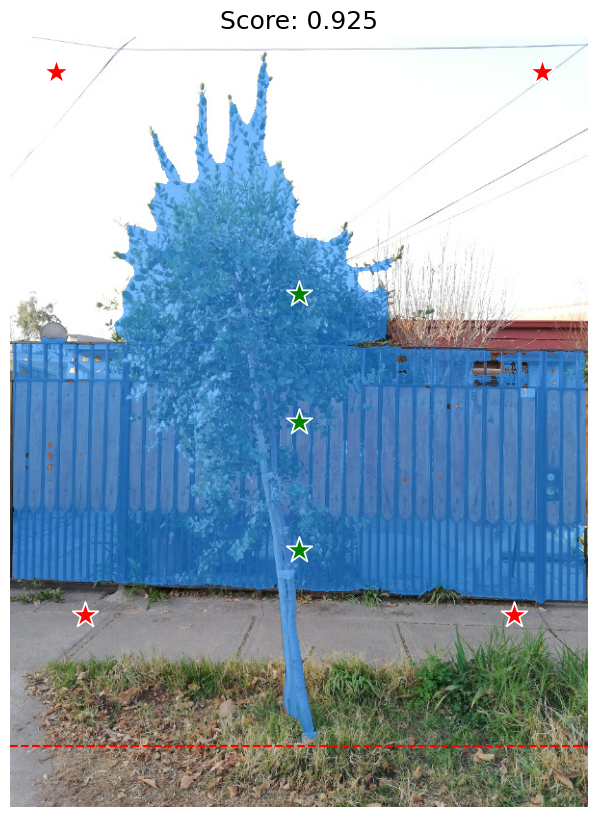

In [2182]:
#grafica la imagen con la mascara y una linea en donde y = 412

plt.figure(figsize=(10,10))
plt.imshow(test_image)
show_mask(best_mask, plt.gca())
show_points(input_points, input_label, plt.gca())
plt.axhline(punto_inflexion, color='red', linestyle='--', label=f'y = 412')
plt.title(f"Score: {score:.3f}", fontsize=18)
plt.axis('off')
plt.show()
